In [1]:
import numpy as np
from scipy import spatial, optimize
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import matplotlib.pylab as plt
import os
from scipy import spatial
from sklearn.decomposition import PCA

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-neilv2wl because the default path (/home/agitated_curran/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
class GPregressor :
    def __init__(self, Input_dim, Nb_points, kernel):
        """Initializing the GPR parameters :
            Inputs : 
                - Input_dim : the dimentionality of the input 
                - Nb_points : the number of points in the training dataset
                - kernel : the covariance function it will use
        """
        self.dim_i = Input_dim
        self.Nb = Nb_points
        self.kernel = kernel
        self.Cov_mat = []

    def unmake_xy(self, hand):
        """Function : Unflattens a shape that has 1D vector format to 3D fromat
        Inputs : 
             - shape : vector of concatenated point's coordinates 
        Output :
             - Shape_3d : list of the 3D points of the shape
        """
        return np.vstack([hand[range(0, len(hand), 3)], hand[range(1, len(hand), 3)], hand[range(2, len(hand), 3)]]).T

    def make_xy(self, hand) :
        """Function : Flattens a shape that has 3D vector format to 1D format
        Inputs : 
             - Shape_3d : list of the 3D points of the shape
        Output :
             - shape : vector of concatenated point's coordinates 
             
        """
        return hand.flatten()

    def Cov_func(self, Points):
        """Function : Computes the reduced covariance matrix given a list of points using the specified kernel"""
        #kernel = 1.0 * Matern(length_scale=l, nu=n)+ ConstantKernel()+ WhiteKernel(noise_level=0.001)
        return self.kernel(Points)

    def fit(self, Training_shapes) :

        """Function : Train the model on multiple Training shapes 
            Inputs : 
                - Training_shapes : list of all the shapes in the train dataset
            Outputs :
                - Updates the GPR covariance matrix 
        """

        ## Initializing the reduced cov matrix
        Reduced_cov = np.zeros((self.Nb, self.Nb))
        for i in range(len(Training_shapes)) :
            # Computing the reduced covariance matrix for each shape deformation in the training set
            Reduced_cov += self.Cov_func(self.unmake_xy(Training_shapes[i, :]))

        Reduced_cov /= len(Training_shapes)

        # Computing the covariance matrix from the reduced form 
        Cov_matrix = np.zeros((self.dim_i*Reduced_cov.shape[0], self.dim_i*Reduced_cov.shape[0]))
        for i in range(self.Nb):
            for j in range(self.Nb) :
                Cov_matrix[self.dim_i*i:self.dim_i*(i+1), self.dim_i*j:self.dim_i*(j+1)] = Reduced_cov[i, j]*np.eye(self.dim_i)
        
        self.Cov_mat = Cov_matrix

    def predict(self, Incomplete_shape, Indexes) :
        """Function : Predicts the missing regions of an incompete mesh
            Inputs : 
                - Incomplete_shape : a flat vector representing the mesh 
                - Indexes : list of the missing points Indexes
            Outputs :
                - Zipped_data : return the complete input shape by filling the missing nodes 
        """

        # Defining the set of observed deformation 
        observed_points = Incomplete_shape[Indexes==1]

        # Defining the blocks of covariance matrix 
        Kxy = self.Cov_mat[Indexes==0, :][:, Indexes==1]
        Kyy = self.Cov_mat[Indexes==1, :][:, Indexes==1]

        # Computing the posterior mean shape
        Predicted_points = Kxy@np.linalg.inv(Kyy)@observed_points

        # Combining the predicted deformations with the observed ones 
        Zipped_data = np.zeros(Incomplete_shape.shape)
        Zipped_data[Indexes==0] = Predicted_points
        Zipped_data[Indexes==1] = observed_points

        return Zipped_data

In [3]:
from tools.tools_constants import (
    PATH_DATASET,
    DELAY_FEATURE
)
from tools.tools_database import (
    read_data, 
    remove_outliers, 
    load_coords
)
from tools.tools_preprocessing import (
    coords_encoding
)

In [4]:
dataset = read_data(PATH_DATASET)

score_threshold = 3
dataset = remove_outliers(dataset, score_threshold)
dataset.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,...,110,6.511118,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,...,22,5.696096,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,...,26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,...,8,6.724757,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,...,17,3.346487,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


In [5]:
colonnes = ['gare_depart',	'gare_arrivee']
L = load_coords(path='./Data/Coords.pickle')
gare_depart_coord_x = []
gare_depart_coord_y = []
gare_arrivee_coord_x = []
gare_arrivee_coord_y = []

# print(len(dataset[colonnes[0]]))
for j in range(len(dataset[colonnes[0]])):
    # print(j, dataset.iloc[j][colonnes[0]])
    gare_depart_coord_x.append(L[dataset.iloc[j][colonnes[0]]][0])
    gare_depart_coord_y.append(L[dataset.iloc[j][colonnes[0]]][1])
    gare_arrivee_coord_x.append(L[dataset.iloc[j][colonnes[1]]][0])
    gare_arrivee_coord_y.append(L[dataset.iloc[j][colonnes[1]]][1])

dataset['gare_depart_coord_x'] = gare_depart_coord_x
dataset['gare_depart_coord_y'] = gare_depart_coord_y
dataset['gare_arrivee_coord_x'] = gare_arrivee_coord_x
dataset['gare_arrivee_coord_y'] = gare_arrivee_coord_y
dataset['month'] = dataset['date'].dt.month
dataset['year'] = dataset['date'].dt.year

In [6]:
last_month_delay = []

n = 0
for j in range(len(dataset['date'])) :
    Row = dataset.iloc[j]
    Frame = dataset[dataset['gare_depart']==Row['gare_depart']]# & dataset['gare_arrivee']==Row['gare_arrivee']]
    Frame = Frame[Frame['gare_arrivee']==Row['gare_arrivee']]
    L = np.where(Frame["date"] == Row['date'])[0][0]
    if L>0 : 
        last_month_delay.append(Frame.iloc[L-1]['retard_moyen_arrivee'])
    else : 
        last_month_delay.append(0)
        n += 1 

print(n)

dataset['retard_mois_prec'] = last_month_delay
dataset.head()

130


,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,gare_depart_coord_x,gare_depart_coord_y,gare_arrivee_coord_x,gare_arrivee_coord_y,month,year,retard_mois_prec
0,2018-01-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,...,15.966387,5.042017,0.840336,44.8252,-0.5467,48.8406,2.3200,1,2018,0.0
1,2018-01-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,...,11.538462,3.846154,0.000000,46.1555,-1.1516,48.8406,2.3200,1,2018,0.0
2,2018-01-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,...,19.230769,0.000000,0.000000,48.8406,2.3200,47.9946,-4.0984,1,2018,0.0
3,2018-01-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,...,15.384615,7.692308,0.000000,48.8406,2.3200,48.6475,-2.0116,1,2018,0.0
4,2018-01-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,...,21.212121,6.060606,0.000000,48.8406,2.3200,47.3906,0.7234,1,2018,0.0


In [7]:
Features = ['nb_train_prevu', 'gare_depart_coord_x', 'gare_depart_coord_y', 'gare_arrivee_coord_x', 'gare_arrivee_coord_y', 'month', 'year', 'retard_mois_prec', 'duree_moyenne']

Output = ['retard_moyen_arrivee', 'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
       'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
       'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
       'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
       'prct_cause_prise_en_charge_voyageurs']

In [8]:
X_train, y_train = dataset[dataset['date'].dt.year != 2023][Features], dataset[dataset['date'].dt.year != 2023][Output]
X_test, y_test = dataset[dataset['date'].dt.year == 2023][Features], dataset[dataset['date'].dt.year == 2023][Output]

In [9]:
X_train.head()

,nb_train_prevu,gare_depart_coord_x,gare_depart_coord_y,gare_arrivee_coord_x,gare_arrivee_coord_y,month,year,retard_mois_prec,duree_moyenne
0,870,44.8252,-0.5467,48.8406,2.3200,1,2018,0.0,141
1,222,46.1555,-1.1516,48.8406,2.3200,1,2018,0.0,165
2,248,48.8406,2.3200,47.9946,-4.0984,1,2018,0.0,220
3,102,48.8406,2.3200,48.6475,-2.0116,1,2018,0.0,156
4,391,48.8406,2.3200,47.3906,0.7234,1,2018,0.0,61


In [10]:
y_train.head()

,retard_moyen_arrivee,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,28.436735,110,6.511118,44,8,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,21.524020,22,5.696096,5,0,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,55.692308,26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,48.623077,8,6.724757,6,4,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,12.405164,17,3.346487,6,0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000


In [11]:
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# X_train = np.array(scaler.fit_transform(X_train))
# X_test = np.array(scaler.transform(X_test))

X_train, X_test = np.array(X_train), np.array(X_test)

y_train, y_test = np.array(y_train), np.array(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7331, 9), (7331, 11), (719, 9), (719, 11))

In [12]:
Train_stations = []
for i in range(len(X_train)) :
    Train_stations.append(dataset.iloc[i]['nb_train_prevu'])


S = np.unique(Train_stations)
Train_stations = np.array(Train_stations)

for i in range(len(S)) :
    Train_stations[Train_stations==S[i]] = i

Train_stations = Train_stations.astype(int)

In [13]:
from sklearn import datasets, ensemble
from sklearn.metrics import r2_score, mean_squared_error

params = {
    "n_estimators": 2000,
    "max_depth": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, np.array([y_train[:, 0]]).T)

y_pred = reg.predict(X_test)
r2_score(np.array([y_test[:, 0]]).T, y_pred), mean_squared_error(np.array([y_test[:, 0]]).T, y_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.3267120571799458, 121.55814230354748)

In [14]:
import xgboost as xgb 

dtrain = xgb.DMatrix(X_train, label=np.array([y_train[:, 0]]).T)
dtest = xgb.DMatrix(X_test, label=np.array([y_test[:, 0]]).T)

param = {'max_depth': 7}
bst = xgb.train(param, dtrain)

ypred = bst.predict(dtest)
r2_score(np.array([y_test[:, 0]]).T, ypred), mean_squared_error(np.array([y_test[:, 0]]).T, ypred)

(0.305243340867718, 125.43419162298962)

In [15]:
reg = xgb.XGBRegressor(tree_method="hist", device="cuda", )
reg.fit(X_train, np.array([y_train[:, 0]]).T)
reg.score(X_test, np.array([y_test[:, 0]]).T)

/home/agitated_curran/.local/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [17:18:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.25242563079276403

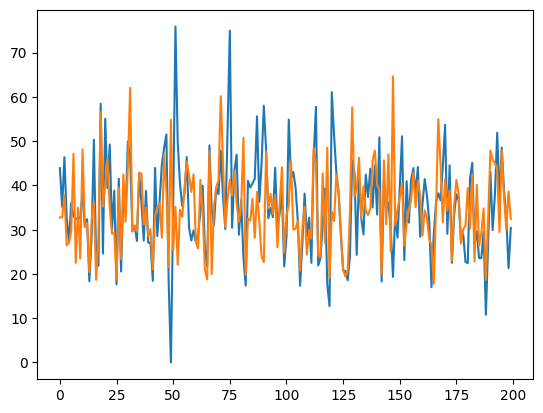

In [16]:
plt.plot(np.array([y_test[:, 0][:200]]).T)
plt.plot(reg.predict(X_test)[:200]) #, np.array([y_test[:, 0]]).T

plt.show()

In [18]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, np.array([y_train[:, 0]]).T)
y_pred = neigh.predict(X_test)

